In [2]:
# libraries
import numpy as np
import pandas as pd
import os
import re

from operator import truediv
from matplotlib.pyplot import figure
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
rcParams['font.weight'] = 200
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

def extract_avg(speeds):
    result = re.findall(r"[-+]?\d*\.\d+|\d+", speeds)
    return float(result[1])

def extract_current(speeds):
    result = re.findall(r"[-+]?\d*\.\d+|\d+", speeds)
    return float(result[0])

def extract_time(time):
    result = re.findall(r"[-+]?\d*\.\d+|\d+", time)
    return int(float(result[1]))

def Read(workload, folder = "."):
    wa = [1,2,3,4,5]
    wip0  = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed'])  # disable read aware compaction
    wip   = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
    peb   = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
    rocks = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
    level = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
    

    with open(folder + "/kv_" + workload + "_disableReadAwareCompaction.log") as origin_file:
        for line in origin_file:
            if line.startswith("20"):
                data = line.strip().split()
                data = [data[i] for i in (10,3,4,7)]
                wip0.loc[len(wip0)] = data
            if line.startswith("WriteAm"): 
                data = line.split() #split string into a list
                wa[0] = float(data[1])
    
    with open(folder + "/kv_" + workload + ".log") as origin_file:
        for line in origin_file:
            if line.startswith("20"):
                data = line.strip().split()
                data = [data[i] for i in (10,3,4,7)]
                wip.loc[len(wip)] = data
            if line.startswith("WriteAm"): 
                data = line.split() #split string into a list
                wa[1] = float(data[1])
    
    with open(folder + "/peb_" + workload + ".log") as origin_file:
        for line in origin_file:
            if line.startswith("20"):
                data = line.strip().split()
                data = [data[i] for i in (10,3,4,7)]
                peb.loc[len(peb)] = data
            if line.startswith("WriteAm"): 
                data = line.split() #split string into a list
                wa[2] = float(data[1])
                
    with open(folder + "/rocks_" + workload + ".log") as origin_file:
        for line in origin_file:
            if line.startswith("20"):
                data = line.strip().split()
                data = [data[i] for i in (10,3,4,7)]
                rocks.loc[len(rocks)] = data
            if line.startswith(" Sum"): 
                data = line.split() #split string into a list
                wa[3] = float(data[11])
                
    with open(folder + "/level_" + workload + ".log") as origin_file:
        for line in origin_file:
            if line.startswith("20"):
                data = line.strip().split()
                data = [data[i] for i in (10,3,4,7)]
                level.loc[len(level)] = data
            if line.startswith("WriteAm"): 
                data = line.split() #split string into a list
                wa[4] = float(data[1])
                
    df = pd.DataFrame(columns = []) 
    
    
    df['LevelDB']       = level['speed'].apply(extract_current)
    print("LevelDB record", level['speed'].count())
    for i in range(8):
        df['LevelDB_thread_speed' + str(i)] = level[level['thread']==str(i) + ":"]['speed'].apply(extract_current) / 1000.0
        df['LevelDB_thread_time' + str(i)] = level[level['thread']==str(i) + ":"]['time'].apply(extract_time)
        

    df['WipDB']       = wip['speed'].apply(extract_current)
    print("WipDB record", wip['speed'].count())
    for i in range(8):
        df['WipDB_thread_speed' + str(i)] = wip[wip['thread']==str(i) + ":"]['speed'].apply(extract_current) / 1000.0
        df['WipDB_thread_time' + str(i)] = wip[wip['thread']==str(i) + ":"]['time'].apply(extract_time)

    df['WipDB-DRC']      = wip0['speed'].apply(extract_current)
    print("WipDB_NoReadCompation record", wip0['speed'].count())
    for i in range(8):
        df['WipDB-DRC_thread_speed' + str(i)] = wip0[wip0['thread']==str(i) + ":"]['speed'].apply(extract_current) / 1000.0
        df['WipDB-DRC_thread_time' + str(i)] = wip0[wip0['thread']==str(i) + ":"]['time'].apply(extract_time)


        
    df['PebblesDB']       = peb['speed'].apply(extract_current)
    print("PebblesDB record", peb['speed'].count())
    for i in range(8):
        df['PebblesDB_thread_speed' + str(i)] = peb[peb['thread']==str(i) + ":"]['speed'].apply(extract_current) / 1000.0
        df['PebblesDB_thread_time' + str(i)] = peb[peb['thread']==str(i) + ":"]['time'].apply(extract_time)
    
    
    df['RocksDB']       = rocks['speed'].apply(extract_current)
    print("RocksDB record", rocks['speed'].count())
    for i in range(8):
        df['RocksDB_thread_speed' + str(i)] = rocks[rocks['thread']==str(i) + ":"]['speed'].apply(extract_current) / 1000.0
        df['RocksDB_thread_time' + str(i)] = rocks[rocks['thread']==str(i) + ":"]['time'].apply(extract_time)
    
    df.to_csv("test0.csv")
    return df, wa, wip0, wip, peb, level, rocks


In [3]:
df0, wa0, wip_0, wip0, peb0, level0, rocks0 = Read("readuniwhilewriting", "./uni2")
df1, wa1, wip_1, wip1, peb1, level1, rocks1 = Read("readexpwhilewriting", "./exp2")

LevelDB record 1736
WipDB record 944
WipDB_NoReadCompation record 926
PebblesDB record 1142
RocksDB record 980
LevelDB record 1664
WipDB record 1034
WipDB_NoReadCompation record 971
PebblesDB record 1520
RocksDB record 1097


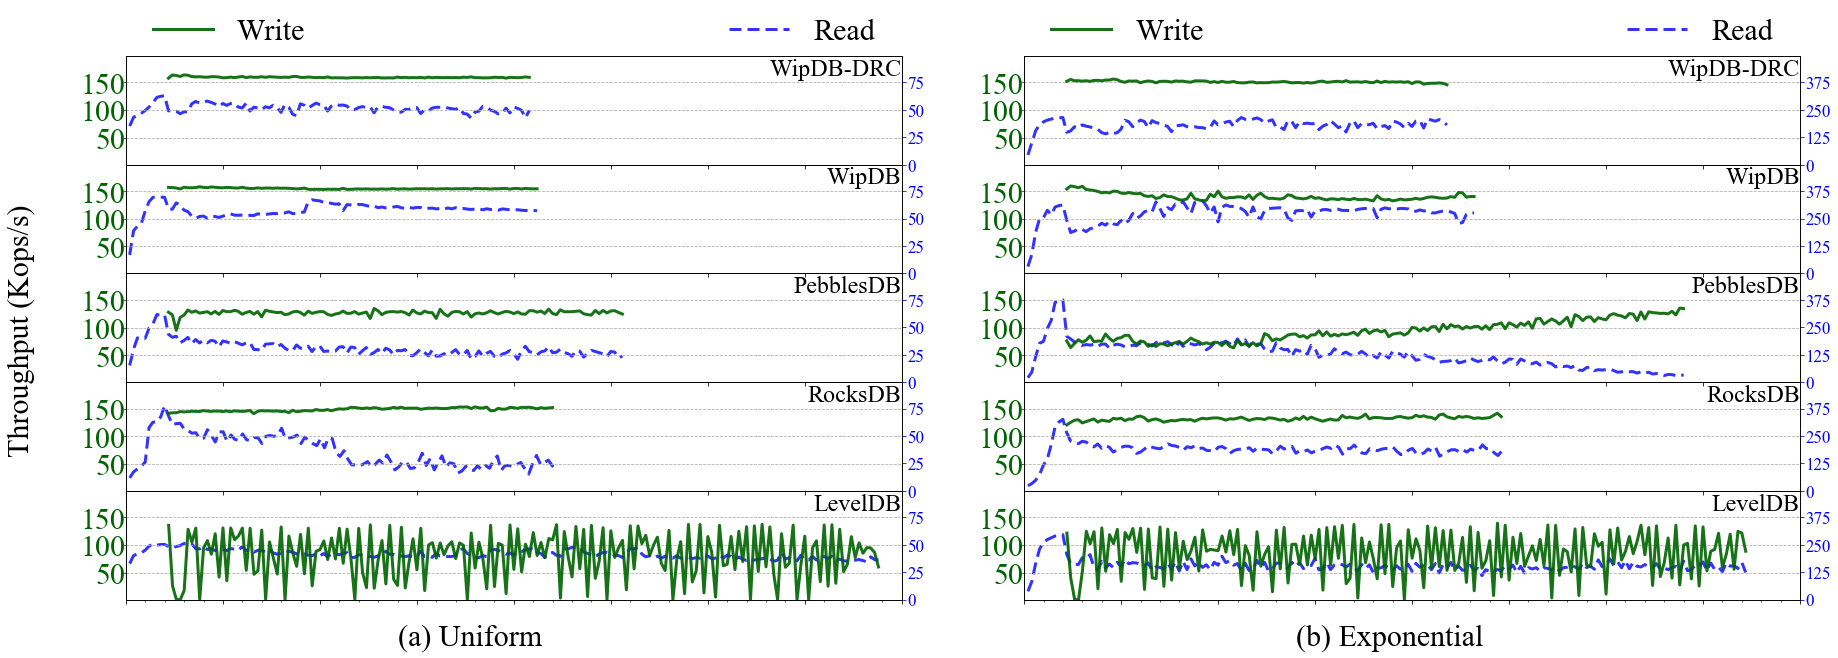

In [11]:
def Plot(df, wa, ax, ylim=200, ystep=50, m_title="123", m_alpha=0.1, xlim=2000, ioData = []):
    words = ['WipDB-DRC', 'WipDB', 'PebblesDB', 'RocksDB', 'LevelDB']
    lw = 3
    for i in range(len(words)):
        wdf = pd.DataFrame(columns = []) 
        # extract read
        ax0t = ax[i].twinx()
        for j in range(1,8):
            thread_read = df[df[words[i] + '_thread_speed' + str(j)].notnull()][words[i] + '_thread_speed' + str(j)]
            thread_read.reset_index(drop=True, inplace=True)
            if words[i] + '_read' in wdf.columns:
                wdf[words[i] + '_read'] = wdf[words[i] + '_read'] + thread_read
            else:
                wdf[words[i] + '_read'] = thread_read
        read_time  = df[df[words[i] + '_thread_speed1'].notnull()][words[i] + '_thread_time1']
        read_time.reset_index(drop=True, inplace=True)
        wdf[words[i] + '_read_time'] = read_time
        
        # extract write
        write_speed = df[df[words[i] + '_thread_speed0'].notnull()][words[i] + '_thread_speed0']
        write_speed.reset_index(drop=True, inplace=True)
        wdf[words[i] + '_write']  = write_speed
        write_time  = df[df[words[i] + '_thread_speed0'].notnull()][words[i] + '_thread_time0'] + 200
        write_time.reset_index(drop=True, inplace=True)
        wdf[words[i] + '_write_time'] = write_time
        
        
        
        # plot write and read line
        wdf.plot(x=words[i] + '_write_time', y=words[i] + '_write', ax=ax[i], fontsize=30, color='darkgreen', markevery=1, markersize=3,  alpha=0.9, linewidth=lw)
        wdf.plot(x=words[i] + '_read_time',  y=words[i] + '_read' , ax=ax0t,  fontsize=30, color='b', dashes=[4, 2], markersize=3,  alpha=0.8, linewidth=lw)
        
#         print(wdf)
        # set legend
        ax[i].legend().set_visible(False)
        ax0t.legend().set_visible(False)
        if (i == 0):
            ax[i].legend(["Write"] , fontsize=30, frameon=False, bbox_to_anchor=(0., 0.85, 0.5, .1), loc='lower left')
            ax0t.legend(["Read"], fontsize=30, frameon=False, bbox_to_anchor=(0.5, 0.85, 0.5, .1), loc='lower right')
            
        # plot title
        if i == 4:
            ax[i].text(xlim*0.35, -80, m_title, fontsize=30)
        
        # set plot style
        ax[i].tick_params(axis='y', colors='darkgreen', pad=-3)  
        ax0t.tick_params(axis='y', colors='b', pad=2, labelrotation=0, labelsize=17)
        ax[i].set_xlim([1, xlim])
        ax[i].set_ylim([1, 198])
        ax0t.set_xlim([1, xlim]) 
        ax0t.set_ylim([1, ylim])
        ax[i].grid(axis='y', linestyle='--')
        ax0t.yaxis.set_ticks(np.arange(0, ylim, ystep))
        
        # print dbname
        ax[i].text(xlim, 164, words[i], horizontalalignment='right', fontsize=24) # print db name
        ax[i].set_zorder(10)
        ax[i].patch.set_visible(False)
        
        # set xtick style
        def seconds(x, pos):
            return '%1.0f' % (x/1000)
        formatter = FuncFormatter(seconds)
        ax[i].xaxis.set_major_formatter(formatter)
        
    ax[4].set_xticks(np.arange(xlim))
    labels = ax[4].get_xticks()
    ax[4].set_xticklabels(labels)
    ax[4].xaxis.set_major_locator(mticker.MultipleLocator(500))
    ax[4].xaxis.set_minor_locator(mticker.MultipleLocator(100))
    ax[4].xaxis.set_minor_formatter(mticker.NullFormatter())
    

fig = plt.figure(figsize=(30, 10)) 
gs = gridspec.GridSpec(10, 21) 
gs.update(wspace=1, hspace=0) # set the spacing between axes. 
ax  = [1,2,3,4,5]
ax2 = [1,2,3,4,5]
ax[0] = plt.subplot(gs[:2, 0:10])
ax[1] = plt.subplot(gs[2:4, 0:10])
ax[2] = plt.subplot(gs[4:6, 0:10])
ax[3] = plt.subplot(gs[6:8, 0:10])
ax[4] = plt.subplot(gs[8:10, 0:10])
ax2[0] = plt.subplot(gs[:2,  11:])
ax2[1] = plt.subplot(gs[2:4, 11:])
ax2[2] = plt.subplot(gs[4:6, 11:])
ax2[3] = plt.subplot(gs[6:8, 11:])
ax2[4] = plt.subplot(gs[8:10, 11:])

# wip0, wip, peb, rocks, level
# {Write IO, Read IO, WA}
uni_data = [4.3, 5.9, 11.8, 20.8, 18.6]
Plot(df0, wa0, ax, 99, 25, "(a) Uniform", 0.07, 4000, uni_data)

exp_data = [4.3 ,4.98, 12.1, 20.4, 18.7]
Plot(df1, wa1, ax2, 495, 125, "(b) Exponential", 0.07, 4000, exp_data)
fig.text(0.07, 0.5, 'Throughput (Kops/s)', va='center', rotation='vertical', fontsize=30)

plt.savefig('readwhilewriting_uni.pdf', bbox_inches='tight')
